## Import modules and functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import matplotlib.ticker as ticker
import pims
import fnmatch
from skimage import io
import os.path, time

## Specify experiment directory

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa'

## Load dataframes of individual experiments

In [3]:
df0307=pd.read_pickle('/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190307_TNR550_BicTTX/190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40/190307_133419_Plate 1/20191003_longterm_intensities.pkl')
df0307["expname"]="0307"

In [4]:
df0315=pd.read_pickle('/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190311_TNR550_Bic/190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51/190315_125329_Plate 1/longterm_intensities_twofoldersconcatenated.pkl')
df0315["expname"]="0315"

In [5]:
df0327=pd.read_pickle('/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/20191003_longterm_intensities.pkl')
df0327["expname"]="0327"

## Concatenate experiments

In [6]:
dfall=pd.concat([df0307,df0315,df0327],axis=0,ignore_index=True)
dfall=dfall.reset_index()

## Make vectors normalized to first value

In [7]:
indexes=[]
for i in range(0,len(dfall)):
    if np.isnan(dfall["intensities vector"][i]).any():
        indexes.append(i)
dfall=dfall.drop(index=indexes)
dfall=dfall.reset_index()
dfall["intensities vector normd"] = dfall.apply(lambda row: row["intensities vector"]/row["intensities vector"][0],axis=1)
dfall["intensities vector bgsub normd"] = dfall.apply(lambda row: row["intensities vector bgsub"]/row["intensities vector bgsub"][0],axis=1)

In [12]:
dfall.to_pickle(expdir+'20191005_merged_dataframes_allexps.pkl')

## Plot normalized vector for each experiment

length = 46
length = 42
length = 70


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


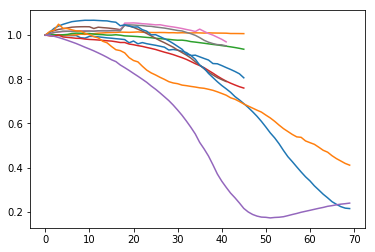

In [11]:
toplot="intensities vector normd"

for exp in dfall["expname"].unique():
    dfexp=dfall[dfall["expname"]==exp]
    dfexp=dfexp.reset_index(drop=True)
    print('length = '+str(len(dfexp["intensities vector"][0])))
    for condition in dfall["condition"].unique():

        df2plot=dfexp[dfexp["condition"]==condition]
        plt.plot(np.mean(df2plot[toplot].tolist(),axis=0))

## Get equal length vectors from experiments

In [12]:
dfall["intensities vector 42 tps"]=dfall.apply(lambda row: row["intensities vector"][0:42],axis=1)
dfall["intensities vector bgsub 42 tps"]=dfall.apply(lambda row: row["intensities vector bgsub"][0:42],axis=1)
dfall["intensities vector normd 42 tps"]=dfall.apply(lambda row: row["intensities vector normd"][0:42],axis=1)
dfall["intensities vector bgsub normd 42 tps"]=dfall.apply(lambda row: row["intensities vector bgsub normd"][0:42],axis=1)
Time=[]
timevec=np.arange(0,42)*4
for i in range(0,len(dfall)):
    Time.append(timevec)
dfall["Time"]=Time

## Plot first 4 days - with regression line

length = 42
length = 42


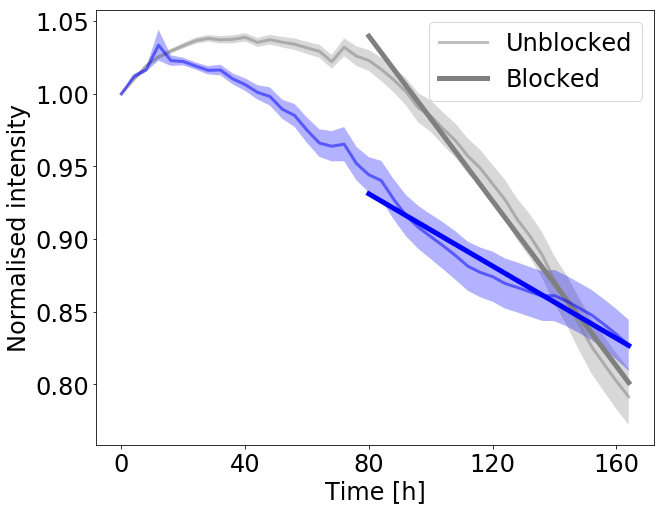

In [15]:
from matplotlib import ticker
import scipy
toplot="intensities vector normd 42 tps"
conditioni=[]
color=[]
dfall2conditions=dfall[(dfall["condition"]!='Blocked + Bic')&(dfall["condition"]!='Blocked + TTX')&(dfall["condition"]!='Autofluorescence')]

plt.figure(figsize=(10,8))
for condition in dfall2conditions["condition"].unique():
    conditioni.append(condition)
    df2plot=dfall2conditions[dfall2conditions["condition"]==condition]
    df2plot=df2plot.reset_index(drop=True)
    print('length = '+str(len(df2plot[toplot][0])))
    if condition=="Unblocked":
        color="gray"
    if condition=="Blocked":
        color="blue"
    plt.plot(np.mean(df2plot[toplot].tolist(),axis=0),color=color,alpha=.5,linewidth=3)
            
    
    #fit regression line
    x = np.arange(20,42)
    y = np.mean(df2plot[toplot].tolist(),axis=0)[20:]
    fit = np.polyfit(x,y,1)
    fit_fn = np.poly1d(fit) 
    plt.plot(x, fit_fn(x),color=color,linewidth=5)
    
    yerr=[scipy.stats.sem(df2plot[toplot].tolist(),axis=0)][0]
    y=[np.mean(df2plot[toplot].tolist(),axis=0)][0]
    x=np.arange(0,42)
    plt.fill_between(x,y-yerr,y+yerr,alpha=.3,facecolor=color)

plt.ylabel('Normalised intensity',size=24)
plt.xlabel('Time [h]',size=24)
scale_x=1/4
ticks_x=ticker.FuncFormatter(lambda x, pos: '{0:g}' .format(x/scale_x))
g=plt.gca()
g.xaxis.set_major_formatter(ticks_x)
plt.xticks(size=24)
plt.yticks(size=24)
plt.legend(conditioni,fontsize=24)
#plt.ylim([0,1.1])
#plt.xlim([0,24])

## Full plot (full y axis) - 4 days

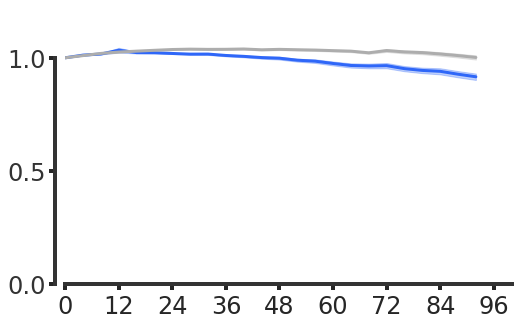

In [44]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

fig=plt.figure(figsize=(8,5))
g=fig.gca()

##plot blocked
dfblocked=dfall[dfall["condition"]=="Blocked"]
plt.plot(np.arange(0,96,4),np.mean(dfblocked[toplot].tolist(),axis=0)[0:24],
         color="#2F67F8",linewidth=3)

x = np.arange(0,96,4)
y=np.mean(dfblocked[toplot].tolist(),axis=0)[0:24]
yerr=np.std(dfblocked[toplot].tolist(),axis=0)[0:24]/(len(dfblocked)**.5)

plt.fill_between(x, y-yerr, y+yerr,
    alpha=0.3, edgecolor='#2F67F8', facecolor='#2F67F8')

##plot unblocked
dfunblocked=dfall[dfall["condition"]=="Unblocked"]
plt.plot(np.arange(0,96,4),np.mean(dfunblocked[toplot].tolist(),axis=0)[0:24]
         ,color="#adadad",linewidth=3)

x = np.arange(0,96,4)
y=np.mean(dfunblocked[toplot].tolist(),axis=0)[0:24]
yerr=np.std(dfunblocked[toplot].tolist(),axis=0)[0:24]/(len(dfunblocked)**.5)

plt.fill_between(x, y-yerr, y+yerr,
    alpha=0.3, edgecolor='#adadad', facecolor='#adadad')

plt.ylim([0,1.2])
plt.xlim([0,100])

plt.rcParams['font.sans-serif'] = 'Helvetica'

for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)


offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,trim=trims,offset=offsets)

#g.set_ylabel('Normalised \nFluorescence intensity',
#             size=24,weight ='bold',labelpad=20,color='#333333')
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks([0,12,24,36,48,60,72,84,96],
           size=24)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)

g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'Supp8biospa_blockedVunblocked.svg', bbox_inches='tight', format='svg')


## Zoomed in panel of difference

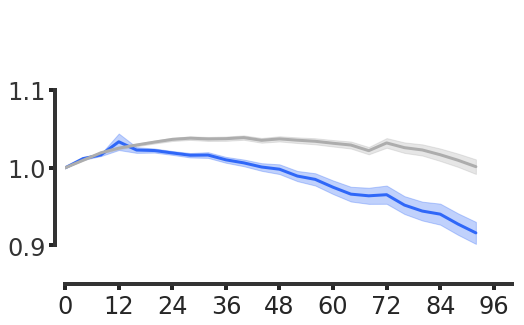

In [45]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

fig=plt.figure(figsize=(8,5))
g=fig.gca()

##plot blocked
dfblocked=dfall[dfall["condition"]=="Blocked"]
plt.plot(np.arange(0,96,4),np.mean(dfblocked[toplot].tolist(),axis=0)[0:24],
         color="#2F67F8",linewidth=3)

x = np.arange(0,96,4)
y=np.mean(dfblocked[toplot].tolist(),axis=0)[0:24]
yerr=np.std(dfblocked[toplot].tolist(),axis=0)[0:24]/(len(dfblocked)**.5)
plt.fill_between(x, y-yerr, y+yerr,
    alpha=0.3, edgecolor='#2F67F8', facecolor='#2F67F8')

##plot unblocked
dfunblocked=dfall[dfall["condition"]=="Unblocked"]
plt.plot(np.arange(0,96,4),np.mean(dfunblocked[toplot].tolist(),axis=0)[0:24]
         ,color="#adadad",linewidth=3)

x = np.arange(0,96,4)
y=np.mean(dfunblocked[toplot].tolist(),axis=0)[0:24]
yerr=np.std(dfunblocked[toplot].tolist(),axis=0)[0:24]/(len(dfunblocked)**.5)
plt.fill_between(x, y-yerr, y+yerr,
    alpha=0.3, edgecolor='#adadad', facecolor='#adadad')

plt.ylim([0.85,1.2])
plt.xlim([0,100])

plt.rcParams['font.sans-serif'] = 'Helvetica'


for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)


offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,trim=trims,offset=offsets)

g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks([0,12,24,36,48,60,72,84,96],
           size=24)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)

g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'Supp8biospa_blockedVunblocked_zoom.svg', bbox_inches='tight', format='svg')



## Zoom with regression line - not used

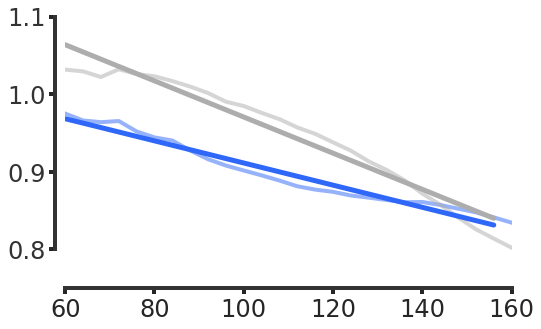

In [162]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

fig=plt.figure(figsize=(8,5))
g=fig.gca()

##plot blocked
dfblocked=dfall[dfall["condition"]=="Blocked"]
plt.plot(np.arange(0,166,4),
         np.mean(dfblocked[toplot].tolist(),axis=0),
         color="#2F67F8",linewidth=4,alpha=.5)

x = np.arange(0,42)
y=np.mean(dfblocked[toplot].tolist(),axis=0)
yerr=np.std(dfblocked[toplot].tolist(),axis=0)/(len(dfblocked)**.5)
#plt.fill_between(x, y-yerr, y+yerr,
#    alpha=0.3, edgecolor='#2F67F8', facecolor='#2F67F8')

##plot unblocked
dfunblocked=dfall[dfall["condition"]=="Unblocked"]
plt.plot(np.arange(0,166,4),
         np.mean(dfunblocked[toplot].tolist(),axis=0), 
         color="#adadad",linewidth=4,alpha=.5)

x = np.arange(0,43)
y=np.mean(dfunblocked[toplot].tolist(),axis=0)
yerr=np.std(dfunblocked[toplot].tolist(),axis=0)/(len(dfunblocked)**.5)
#plt.fill_between(x, y-yerr, y+yerr,
#    alpha=0.3, edgecolor='#adadad', facecolor='#adadad')


#scale_x=1/4
#ticks_x=ticker.FuncFormatter(lambda x, pos: '{0:g}' .format(x/scale_x))
g=plt.gca()
#g.xaxis.set_major_formatter(ticks_x)

plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.ylim([0.75,1.1])
plt.xlim([60,160])

for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)


offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,trim=trims,offset=offsets)

#g.set_ylabel('Normalised \nFluorescence intensity',
#             size=24,weight ='bold',labelpad=20,color='#333333')
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),
           size=24)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)

g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)

#fit regression line
x = np.arange(60,160,4)
y = np.mean(dfblocked[toplot].tolist(),axis=0)[15:40]
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
plt.plot(x, fit_fn(x),color="#2F67F8",linewidth=5)

x = np.arange(60,160,4)
y = np.mean(dfunblocked[toplot].tolist(),axis=0)[15:40]
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
plt.plot(x, fit_fn(x),color="#adadad",linewidth=5)




diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'suppbiospa_blockedVunblocked_zoomedin.svg', bbox_inches='tight', format='svg')



## regression - slope calculation - ignore

In [137]:
import statsmodels.regression.linear_model as sm
df2plot=dfall2conditions[dfall2conditions["condition"]=="Unblocked"]
yerr=[scipy.stats.sem(df2plot[toplot].tolist(),axis=0)][0]
y=[np.mean(df2plot[toplot].tolist(),axis=0)][0]
x=np.arange(0,42)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

df2plot=dfall2conditions[dfall2conditions["condition"]=="Blocked"]
yerr=[scipy.stats.sem(df2plot[toplot].tolist(),axis=0)][0]
y=[np.mean(df2plot[toplot].tolist(),axis=0)][0]
x=np.arange(0,42)
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x,y)

## Number of images

In [47]:
len(dfblocked)+len(dfunblocked)

656